In [2]:
#Script version 05-12 
import numpy as np
from dolfin import * #imports all fuctions within dolfin
import ufl
import matplotlib.pyplot as plt
import random
from matplotlib.tri import Triangulation
from scipy.optimize import minimize

#Solver options 
from petsc4py import PETSc
opts = PETSc.Options()
opts.setValue('ksp_monitor', None)
opts.setValue('ksp_view', None)

#Script version
script_version = "05-12"
print(f"Script version {script_version} initialized successfully, Zoë.")

Script version 05-12 initialized successfully, Zoë.


In [3]:
# --- Physical and turbine parameters ---
rho = 1025.0         # Water density [kg/m³]
g = 9.81             # Gravitational acceleration [m/s²]
depth = 50.0         # Water depth [m]

C_T = 0.6             # Turbine thrust coefficient [-]
C_D = 0.0025          # Drag coefficient [-]
sigma = 5.0          # Wake Gaussian spread [m]
D = 5               # Turbine diameter
A_T = np.pi*D**2            # Turbine swept area [m²]

# --- Flow properties ---
U_inflow = 2.0       # Inflow velocity [m/s]
nu_eff = Constant(1.0)  # Effective viscosity [m²/s]
cb = 0.0025    # Bed friction coefficient [-]
viscosity = 1.0 #for now keep turbulent visc or eddy visc

#H = depth  # total depth (assuming flat bottom for now)
nu = viscosity  # viscosity coefficient

# --- Initial conditions ---
initial_condition_u = Constant((0.0, 0.0))
initial_condition_eta = Constant(0.0) # Start with no surface elevation

print(f"Initialized base parameters successfully.")

Initialized base parameters successfully.


Success! Initialized u_init with U_inflow = 2.0 m/s on a 50x40 mesh.


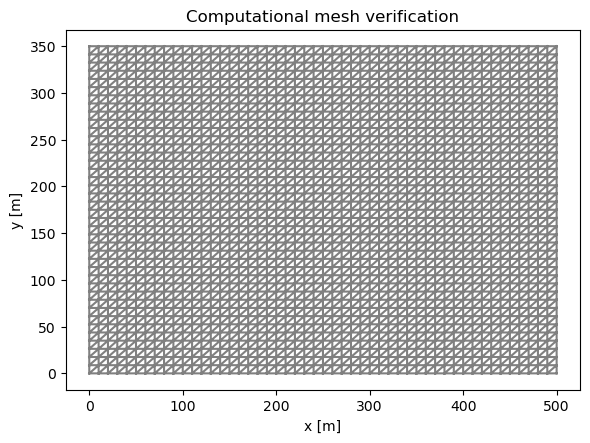

In [5]:
# --- Domain and mesh setup -------------------------------------------------
Lx, Ly = 500.0, 350.0   # Domain size in x and y directions [m]
Nx, Ny = 50, 40           # Number of grid cells in x and y directions

mesh = RectangleMesh(Point(0.0, 0.0), Point(Lx, Ly), Nx, Ny)

# --- Mixed Taylor–Hood function space -------------------------------------
P2 = VectorElement("P", mesh.ufl_cell(), 2)   # Quadratic velocity element
P1 = FiniteElement("P", mesh.ufl_cell(), 1)   # Linear free-surface element
mixed_element = MixedElement([P2, P1])

W = FunctionSpace(mesh, mixed_element)

# --- Define trial functions and test functions ----------------------------
w = Function(W)                 # Combined function: [u, eta]
(u, eta) = split(w)             # u = velocity (u_x, u_y); eta = free-surface elevation
(v, q) = TestFunctions(W)       # Corresponding test functions

# --- Initialize uniform inflow velocity -----------------------------------
V_sub = W.sub(0).collapse()     # Extract velocity subspace from mixed space
u_init = interpolate(Constant((U_inflow, 0.0)), V_sub)
assign(w.sub(0), u_init)        # Assign initial condition to velocity field

# --- Define boundary markers ----------------------------------------------
inflow = 'near(x[0], 0.0)'
outflow = f'near(x[0], {Lx})'
walls = f'near(x[1], 0.0) || near(x[1], {Ly})'

# --- Mesh visualization ---------------------------------------------------
print(f"Success! Initialized u_init with U_inflow = {U_inflow} m/s on a {Nx}x{Ny} mesh.")
plt.figure(figsize=(6, 5))
plot(mesh)
plt.title("Computational mesh verification")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.tight_layout()
plt.show()


✅ Successfully placed 10 turbines after 12 attempts.
Initialized 10 turbines successfully.


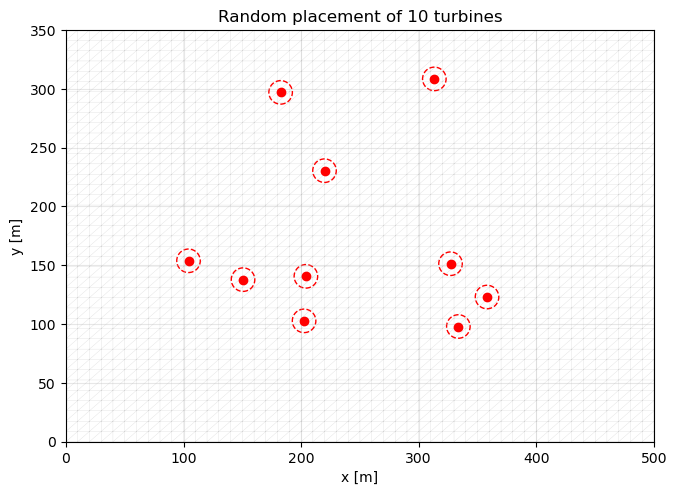

Turbine positions: [(202.51791634709554, 102.76533621613329), (313.2635764120852, 308.50188199644174), (333.6870127840227, 97.96874805823613), (358.075213935051, 123.02874643986469), (204.05461120449962, 140.61365742164668), (182.56352055412182, 297.0338322244652), (219.88085239298118, 230.45738548570657), (327.0233657392971, 151.3493659299658), (104.24707114886215, 153.83241026171427), (150.6135313170445, 137.80893490898552)]


In [6]:
# --- Turbine layout ---
#turbine_positions = [(60.0, 30.0), (60.0, 50.0)]
#n_turbines = len(turbine_positions)

n_turbines = 10             # number of turbines
min_spacing = 5*D     # minimum spacing between turbines [m]
#random.seed(42)             # set a fixed seed for reproducibility

turbine_positions = []
max_att = 500
att = 0

while len(turbine_positions) < n_turbines and att < max_att:
    x_rand = random.uniform(0.2 * Lx, 0.8 * Lx)  # avoid being too close to inlet/outlet
    y_rand = random.uniform(0.1 * Ly, 0.9 * Ly)
    att +=1

    if all(np.hypot(x_rand - x_i, y_rand - y_i) > min_spacing for (x_i, y_i) in turbine_positions):
        turbine_positions.append((x_rand, y_rand))

if len(turbine_positions) < n_turbines:
    print(f"⚠️ Only placed {len(turbine_positions)} turbines after {att} attempts.")
    print("Try reducing min_spacing or the number of turbines.")
else:
    print(f"✅ Successfully placed {n_turbines} turbines after {att} attempts.")

print(f"Initialized {n_turbines} turbines successfully.")

#Show the initial placement of the turbines
plt.figure(figsize=(7, 5))
plot(mesh, linewidth=0.2, color="lightgray")

for (x_i, y_i) in turbine_positions:
    plt.plot(x_i, y_i, 'ro', markersize=6)
    circle = plt.Circle((x_i, y_i), 2*sigma, color='r', fill=False, linestyle='--', linewidth=1)
    plt.gca().add_artist(circle)

plt.xlim(0, Lx)
plt.ylim(0, Ly)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title(f"Random placement of {n_turbines} turbines")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print("Turbine positions:", turbine_positions)

In [8]:
# --- Boundary definition and marking --------------------------------------
class InletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)  # Define inlet at x = 0

class OutflowBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], Lx)   # Outflow at x = Lx

# Create MeshFunction for boundary markers
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)

# Mark inlet boundary with ID = 1
inlet = InletBoundary()
inlet.mark(boundary_markers, 1)

# Outflow boundary with ID = 2 
# We are defining outflow here because later we can use this to get data in x = Lx
outflow = OutflowBoundary()
outflow.mark(boundary_markers, 2)

# --- Inflow velocity boundary condition -----------------------------------
inflow_expr = Constant((U_inflow, 0.0))  # Uniform inflow in x-direction FOR NOW

# Apply Dirichlet boundary condition on velocity (subspace 0)
bc_inflow = DirichletBC(W.sub(0), inflow_expr, boundary_markers, 1)

# Collect all boundary conditions
bcs = [bc_inflow]

print(f"Success! Defined inflow boundary with velocity {U_inflow} m/s.")

Success! Defined inflow boundary with velocity 2.0 m/s.


In [9]:
#Objective function

def objective_function(turbine_positions, velocity_function, rho, C_T, A_T):
    turbine_powers, _ = compute_turbine_power(velocity_function, turbine_positions, rho, C_T, A_T)
    J = np.sum(turbine_powers)
    return J
    
J = objective_function(turbine_positions, w.sub(0), rho, C_T, A_T)
print(f"Objective function (total power): {J/1e6:.3f} MW")

x0 = np.array([coord for pair in turbine_positions for coord in pair])

print(x0)

bounds = []
for _ in range(n_turbines):
    # x between 0.2*Lx and 0.8*Lx
    # y between 0.1*Ly and 0.9*Ly
    bounds.append((0.2*Lx, 0.8*Lx))
    bounds.append((0.1*Ly, 0.9*Ly))

result = minimize(objective_flat, x0, method='L-BFGS-B', bounds=bounds,
                  options={"maxiter": 200, "disp": True})

# --- Extract optimized positions ------------------------------------------
optimized_positions = [(result.x[2*i], result.x[2*i+1]) for i in range(n_turbines)]

print("\nOptimization finished.")
print(f"Initial total power: {-objective_flat(x0)/1e6:.3f} MW")
print(f"Optimized total power: {-result.fun/1e6:.3f} MW")
print("Optimized turbine positions:")
for i, (x_i, y_i) in enumerate(optimized_positions, 1):
    print(f"Turbine {i:2d}: x = {x_i:.2f} m, y = {y_i:.2f} m")

NameError: name 'compute_turbine_power' is not defined

In [10]:
def objective_flat(params):
    # Reformat flat vector -> list of (x, y)
    turbine_positions = [(params[2*i], params[2*i+1]) for i in range(n_turbines)]

    # Call shallow-water solver
    total_power, velocity2 = solve_tidal_flow_velocities(turbine_positions, w, mesh, bcs,
                                   rho, depth, nu, cb, g, C_T, A_T, sigma)
    print(f"Layout objective: {total_power/1e6:.3f} MW")
    
    return -total_power  # negative for minimization (maximize power)


In [11]:
#for safety, may be necessARY LAter
#H_safe = conditional(gt(H, 1e-3), H, 1e-3)

def solve_tidal_flow_velocities(turbine_positions, w, mesh, bcs, rho, depth, nu, cb, g, C_T, A_T, sigma):
# Trial and test functions 
    (u_, eta_) = split(w)      # trial: velocity, free-surface
    (v_, q_) = TestFunctions(W)
    
    n = FacetNormal(mesh)
    H = depth + eta_     # for full nonlinear free-surface coupling
    f_u = Constant((0, 0)) #no internal forcing term - coriolis/windstress/pressure gradient - do look into tidal driving

# --- Turbine-induced momentum sink coefficient field ----------------------
    x, y = SpatialCoordinate(mesh)

# Build Gaussian field for all turbines
    Ct_field = 0
    for (x_i, y_i) in turbine_positions:
        Ct_field += 0.5 * C_T * A_T / (2.0 * np.pi * sigma**2) * exp(-((x - x_i)**2 + (y - y_i)**2) / (2.0 * sigma**2))

# Define the full nonlinear residual form F
        F = (inner(nu * grad(u_), grad(v_)) * dx #viscosity
     + inner(dot(u_, nabla_grad(u_)), v_) * dx #advection
     - g * div(H * v_) * eta_ * dx
     #- g * H * eta_ * div(v_) * dx #pressure gradient for incompr LOOK AT THIS LATER, TWICE THE ELEVATION TAKEN INTO ACCOUNT??
     + (cb/H) * inner(u_ * sqrt(dot(u_, u_)), v_) * dx) #bottom friction

# Turbine momentum sink using spatially varying field
    F += (Ct_field / H) * inner(u_ * sqrt(dot(u_, u_)), v_) * dx
    F += H * div(u_) * q_ * dx - inner(f_u, v_) * dx  # Full residual (no separate L) mass conservation/continuity

# Solve nonlinear problem with Newton's method
    solve(F == 0, w, bcs,
          solver_parameters={"newton_solver": {
              "linear_solver": "mumps",  # or "petsc" with good preconditioner
              "absolute_tolerance": 1e-8,
              "relative_tolerance": 1e-7,
              "maximum_iterations": 30,
              "relaxation_parameter": 1.0
          }})

#compute power 
    velocity2 = w.sub(0, deepcopy=True)
    turbine_powers2, _ = compute_turbine_power(velocity, turbine_positions, rho, C_T, A_T)
    total_power2 = np.sum(turbine_powers)

    return total_power2, velocity2


ds_out = Measure("ds", domain=mesh, subdomain_data=boundary_markers, subdomain_id=2)
outflow_flux = assemble(dot(u, n)*ds_out)
print(f"The outflow flux: {outflow_flux:.1f} m^3/s")

NameError: name 'n' is not defined

In [12]:
# Flatten initial layout
x0 = np.array([coord for pair in turbine_positions for coord in pair])

# Domain bounds
bounds = []
for _ in range(n_turbines):
    bounds.append((0.2*Lx, 0.8*Lx))
    bounds.append((0.1*Ly, 0.9*Ly))

# Run constrained optimization
result = minimize(objective_flat, x0, method='L-BFGS-B', bounds=bounds,
                  options={'maxiter': 5, 'disp': True})


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.806e+00 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton iteration 1: r (abs) = 5.107e-02 (tol = 1.000e-08) r (rel) = 2.828e-02 (tol = 1.000e-07)
  Newton iteration 2: r (abs) = 7.559e-05 (tol = 1.000e-08) r (rel) = 4.185e-05 (tol = 1.000e-07)
  Newton iteration 3: r (abs) = 2.178e-10 (tol = 1.000e-08) r (rel) = 1.206e-10 (tol = 1.000e-07)
  Newton solver finished in 3 iterations and 3 linear solver iterations.


NameError: name 'compute_turbine_power' is not defined

In [13]:
optimized_positions = [(result.x[2*i], result.x[2*i+1]) for i in range(n_turbines)]

print("\nOptimization result summary:")
print(f"Initial total power: {-objective_flat(x0)/1e6:.3f} MW")
print(f"Optimized total power: {-result.fun/1e6:.3f} MW")


NameError: name 'result' is not defined

In [14]:
result_test = solve_tidal_flow_velocities(turbine_positions, w, mesh, bcs,
                                          rho, depth, nu, cb, g, C_T, A_T, sigma)
print(type(result_test))
print(result_test)


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.178e-10 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


NameError: name 'compute_turbine_power' is not defined

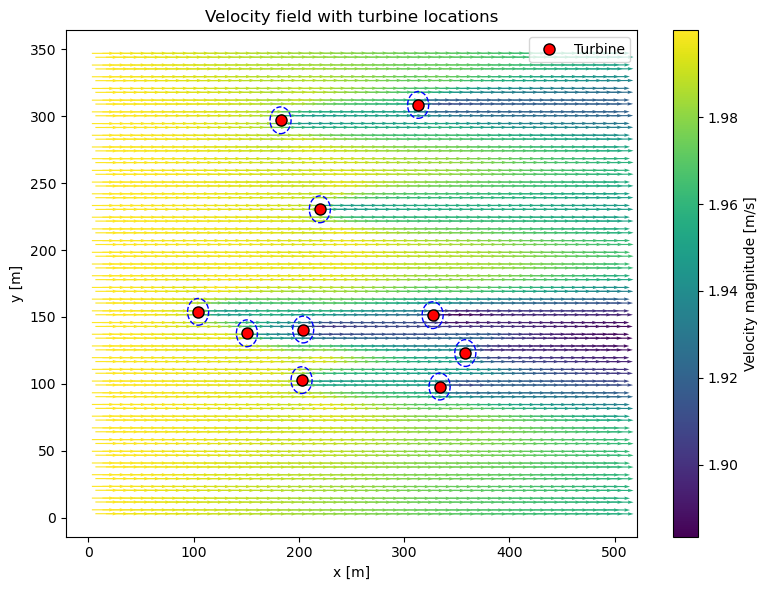

In [15]:
# --- Extract velocity from mixed Function -----------------------------------
velocity = w.sub(0, deepcopy=True)  

mesh2 = w.function_space().mesh()
coords = mesh2.coordinates()
cells = mesh2.cells()

# --- Compute cell midpoints for quiver arrows ------------------------------
midpoints = np.array([np.mean(coords[cell], axis=0) for cell in cells])

# Evaluate velocity and compute magnitude
velocity_values = np.array([velocity(point) for point in midpoints])
u_vals = velocity_values[:, 0]
v_vals = velocity_values[:, 1]
speed = np.sqrt(u_vals**2 + v_vals**2)

# --- Create figure and velocity quiver plot --------------------------------
plt.figure(figsize=(8, 6))
Q = plt.quiver(midpoints[:, 0], midpoints[:, 1], u_vals, v_vals, speed,
               cmap='viridis', scale=50, width=0.002, headwidth=3, zorder=1)
plt.colorbar(Q, label='Velocity magnitude [m/s]')

# --- Overlay turbine locations and influence circles -----------------------
for (x_i, y_i) in turbine_positions:
    plt.plot(x_i, y_i, 'ro', markersize=8, markeredgecolor='k',
             label='Turbine' if 'Turbine' not in plt.gca().get_legend_handles_labels()[1] else "", zorder=3)
    circle = plt.Circle((x_i, y_i), 2*sigma, color='b', fill=False,
                        linestyle='--', linewidth=1, zorder=2)
    plt.gca().add_artist(circle)

# --- Domain labels and layout ----------------------------------------------
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Velocity field with turbine locations")
plt.legend(loc='upper right')
#plt.xlim(0, Lx)
#plt.ylim(0, Ly)
plt.tight_layout()
plt.show()


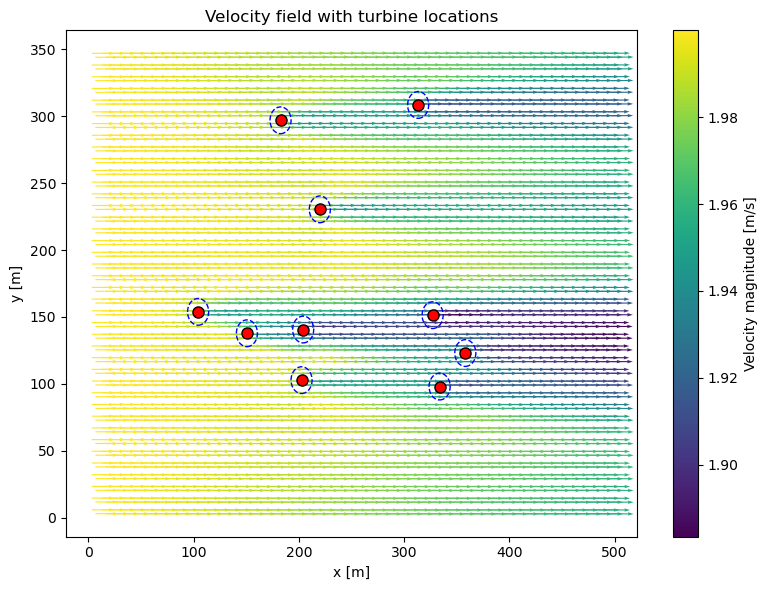

In [16]:
# --- Extract velocity from mixed Function -----------------------------------
velocity = w.sub(0, deepcopy=True)  

# Extract mesh geometry
mesh = velocity.function_space().mesh()
coords = mesh.coordinates()
cells = mesh.cells()

# --- Compute cell centroids for plotting ------------------------------------
midpoints = np.zeros((cells.shape[0], 2))
for i, cell in enumerate(cells):
    pts = coords[cell]
    midpoints[i, :] = np.mean(pts, axis=0)

# --- Evaluate velocity at each centroid -------------------------------------
# velocity(point) expects a tuple, not an array
u_vals = np.zeros(len(midpoints))
v_vals = np.zeros(len(midpoints))
for i, (x, y) in enumerate(midpoints):
    vec = velocity(Point(x, y))
    u_vals[i], v_vals[i] = vec[0], vec[1]

speed = np.sqrt(u_vals**2 + v_vals**2)

# --- Create figure and velocity quiver plot ---------------------------------
plt.figure(figsize=(8, 6))
Q = plt.quiver(midpoints[:, 0], midpoints[:, 1], u_vals, v_vals, speed,
               cmap='viridis', scale=50, width=0.002, headwidth=3, zorder=1)
plt.colorbar(Q, label='Velocity magnitude [m/s]')

# --- Overlay turbine locations ----------------------------------------------
for (x_i, y_i) in turbine_positions:
    plt.plot(x_i, y_i, 'ro', markersize=8, markeredgecolor='k', zorder=3)
    circle = plt.Circle((x_i, y_i), 2*sigma, color='b', fill=False,
                        linestyle='--', linewidth=1, zorder=2)
    plt.gca().add_artist(circle)

plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Velocity field with turbine locations")
plt.tight_layout()
plt.show()


In [17]:
# --- Turbine Power Evaluation ----------------------------------------------

def compute_turbine_power(velocity_function, turbine_positions, rho, C_T, A_T):
    powers, velocities = [], []

    for (x_i, y_i) in turbine_positions:
        u_local = velocity_function((x_i, y_i))         # Local velocity vector
        speed = np.sqrt(u_local[0]**2 + u_local[1]**2)  # Velocity magnitude
        P_i = 0.5 * rho * C_T * A_T * speed**3          # Power extraction
        powers.append(P_i)
        velocities.append(speed)

    return np.array(powers), np.array(velocities)


# --- Compute Power and Velocity per Turbine --------------------------------
turbine_powers, turbine_velocities = compute_turbine_power(
    w.sub(0), turbine_positions, rho, C_T, A_T
)

# --- Theoretical Reference Values -----------------------------------------
C_P = C_T * (1 - 0.5 * C_T)  # Power coefficient (actuator disk relation)

P_theoretical = 0.5 * rho * C_P * A_T * U_inflow**3
P_thrust_based = 0.5 * rho * C_T * A_T * U_inflow**3
Max_park_power = P_thrust_based*n_turbines

print(f"Maximum theoretical power per turbine (Betz-adjusted): {P_theoretical/1e3:.2f} kW")
print(f"Momentum-sink (raw thrust) power per turbine:          {P_thrust_based/1e3:.2f} kW\n")
print(f"Max total power: {P_thrust_based*n_turbines/1e6:.2f} MW")

# --- Output per Turbine and Total ------------------------------------------
total_power = 0.0
print("Turbine performance summary:")
print("-" * 50)
for i, (P, v) in enumerate(zip(turbine_powers, turbine_velocities), 1):
    print(f"Turbine {i:2d}: Velocity = {v:.2f} m/s | Power = {P/1e3:.2f} kW")
    total_power += P

print("-" * 50)
print(f"Total extracted power: {total_power/1e6:.2f} MW\n")
print(f"How much % of possible extractable power: {total_power/Max_park_power*100:.2f}%")


Maximum theoretical power per turbine (Betz-adjusted): 135.25 kW
Momentum-sink (raw thrust) power per turbine:          193.21 kW

Max total power: 1.93 MW
Turbine performance summary:
--------------------------------------------------
Turbine  1: Velocity = 1.96 m/s | Power = 181.45 kW
Turbine  2: Velocity = 1.92 m/s | Power = 171.17 kW
Turbine  3: Velocity = 1.92 m/s | Power = 170.47 kW
Turbine  4: Velocity = 1.91 m/s | Power = 169.52 kW
Turbine  5: Velocity = 1.91 m/s | Power = 167.77 kW
Turbine  6: Velocity = 1.95 m/s | Power = 179.60 kW
Turbine  7: Velocity = 1.95 m/s | Power = 180.14 kW
Turbine  8: Velocity = 1.89 m/s | Power = 164.26 kW
Turbine  9: Velocity = 1.96 m/s | Power = 182.12 kW
Turbine 10: Velocity = 1.95 m/s | Power = 178.82 kW
--------------------------------------------------
Total extracted power: 1.75 MW

How much % of possible extractable power: 90.33%


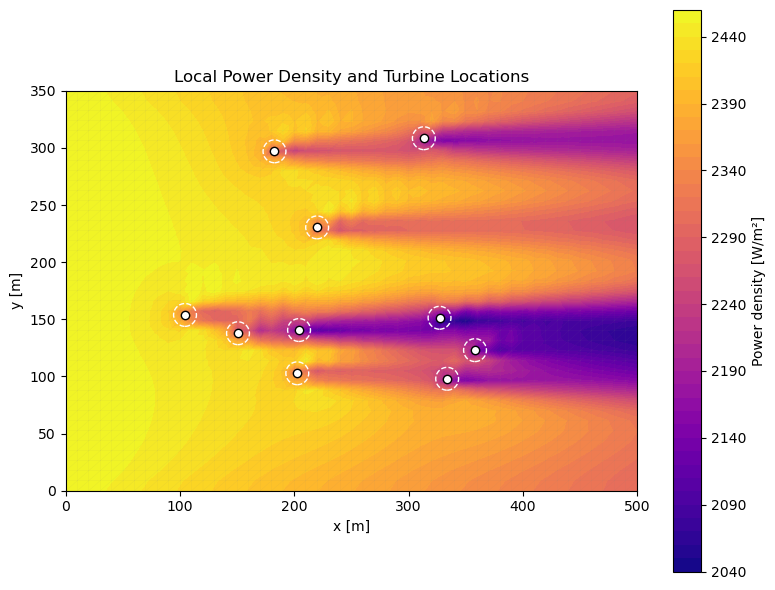

In [18]:
# --- Power density field computation ---------------------------------------

# Extract mesh and coordinates
mesh2 = w.function_space().mesh()
coords = mesh2.coordinates()
cells = mesh2.cells()

# Velocity function and evaluation at mesh vertices
velocity = w.sub(0, deepcopy=True)
vel_array = np.array([velocity(Point(x, y)) for (x, y) in coords])
speed = np.sqrt(vel_array[:, 0]**2 + vel_array[:, 1]**2)

# Power density per unit area (W/m²)
power_density = 0.5 * rho * C_T * (speed**3) * (A_T / (np.pi * (np.sqrt(A_T / np.pi))**2))
# simplified as just 0.5*rho*CT*(speed**3) if you interpret AT as per-turbine thrust area

# Prepare triangulation for contour plotting
triang = Triangulation(coords[:, 0], coords[:, 1], cells)

# --- Visualization ----------------------------------------------------------
plt.figure(figsize=(8, 6))
c = plt.tricontourf(triang, power_density, levels=50, cmap='plasma')
plt.colorbar(c, label='Power density [W/m²]')

# Overlay mesh and turbines
plot(mesh2, linewidth=0.1, color="gray", alpha=0.3)

for (x_i, y_i) in turbine_positions:
    plt.plot(x_i, y_i, 'wo', markersize=6, markeredgecolor='k', zorder=5)
    circle = plt.Circle((x_i, y_i), 2*sigma, color='w', linestyle='--',
                        fill=False, linewidth=1, zorder=4)
    plt.gca().add_artist(circle)

plt.title("Local Power Density and Turbine Locations")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.tight_layout()
plt.show()